# Response Curve 
- Response curve for regressors
1. load picking max / min tmp soil moisture, or scalar field of interest
2. winsorize
3. calculate county level response curves
4. aggregate over us, results in triple curve on one plot with uncertainty, also show the spatial like ronak patels (tapio phd student) paper 

## Packages

In [20]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob
import geopandas as gpd
import xagg as xa
from linearmodels.panel import PanelOLS


## Functions

In [118]:
def train_fe(file_path_SM_hist):
    '''
    given the file path from the preious jupyter notebooks, outputs the model 
    inputs
    - the file path of yearly aggregated feols regressors
    outputs
    - fips_level_inputs_pd as the clean dataset
    '''
    fips_level_inputs_pd = pd.read_csv(file_path_SM_hist) 
    fips_level_inputs_pd = fips_level_inputs_pd.rename(columns={'time': 'year'})
    fips_level_inputs_pd['year_input'] = fips_level_inputs_pd['year']
    fips_level_inputs_pd['year2'] = fips_level_inputs_pd['year']**2
    fips_level_inputs_pd['fips'] = fips_level_inputs_pd['fips'].astype(str).str.zfill(5)
    fips_level_inputs_pd['state'] = fips_level_inputs_pd['fips'].astype(str).str.slice(0, 2)
    return fips_level_inputs_pd

def eff_se_for_m(m):
    d = pd.Series(0.0, index=results_h21.params.index)
    d['SoilM_0_100cm'] = (m - m0) / number_of_days
    d['SoilM_0_100cm_square']  = (m*m - m0*m0) / number_of_days
    
    if SQUARE_IS_MEAN_OF_SQUARES:
        # this is the case sm was square before mean 
        d['SoilM_0_100cm_square'] = ((m**2) - (m0**2)) / number_of_days
    else:
        # this is the case of sm was mean before squaring
        d['SoilM_0_100cm_square'] = 2.0 * m0 * d['SoilM_0_100cm']
        
    b  = results_h21.params.reindex(d.index).fillna(0.0).values
    theta = covariance.reindex(index=d.index, columns=d.index).fillna(0.0).values
    x  = d.values
    eff = 100.0 * float(x @ b)
    se  = 100.0 * float(np.sqrt(x @ theta @ x))
    return eff, se

## Preprocessing similar to 6_implementation_2a.ipynb

In [7]:
csv_output_file_haqiqi2021_2aVIC = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/VIC_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
csv_output_file_haqiqi2021_2aNOAH = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/NOAH_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
csv_output_file_haqiqi2021_2aMOS = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/MOS_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"

usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"

sm_labels = ['VIC', 'NOAH', 'MOSAIC']

In [8]:
counties = gpd.read_file(county_shp_path)
usda_pd = pd.read_csv(usda_filepath)
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]
# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')
# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]
usda_pd['log_yield'] = np.log(usda_pd['yield'])

In [10]:
fips_level_inputs_pd_VIC = train_fe(csv_output_file_haqiqi2021_2aVIC)
fips_level_inputs_pd_NOAH = train_fe(csv_output_file_haqiqi2021_2aNOAH)
fips_level_inputs_pd_MOS = train_fe(csv_output_file_haqiqi2021_2aMOS)
list_historic_sm = [fips_level_inputs_pd_VIC, fips_level_inputs_pd_NOAH, fips_level_inputs_pd_MOS]
df_set_index_arr = []
# merge usda_pd & histdata 
for soil_moisture_comibination_i in list_historic_sm:
    
    df = soil_moisture_comibination_i.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
    df['year2'] = df['year']**2
    
    rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                       "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                       "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                       "46", "47", "48", "50", "51", "54", "55"]
    
    df = df[df['state'].isin(rainfed_states)]
    df_set_index = df.set_index(['fips', 'year'])
    df_set_index_arr.append(df_set_index) # the arr of dataframes is ordered by the list_historic (so VIC then NOAH then MOS)

In [ ]:
# define the model with compound extremes & state specific trends

formula = (
    'log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + '
    'edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + '
    'C(state):year_input + C(state):year2 + EntityEffects'
)
model_arr = []
results_h21_arr = []
predictions_arr = []
for df_set_index_i in df_set_index_arr:
    model = PanelOLS.from_formula(formula, data=df_set_index_i)
    results_h21 = model.fit(cov_type='clustered', clusters=df_set_index_i['state'])
    predictions = results_h21.predict(effects=True)
    predictions['total_pred'] = predictions['fitted_values'] + predictions['estimated_effects']
    model_arr.append(model)
    results_h21_arr.append(results_h21)
    predictions_arr.append(predictions)

## Calculation of Response Curve

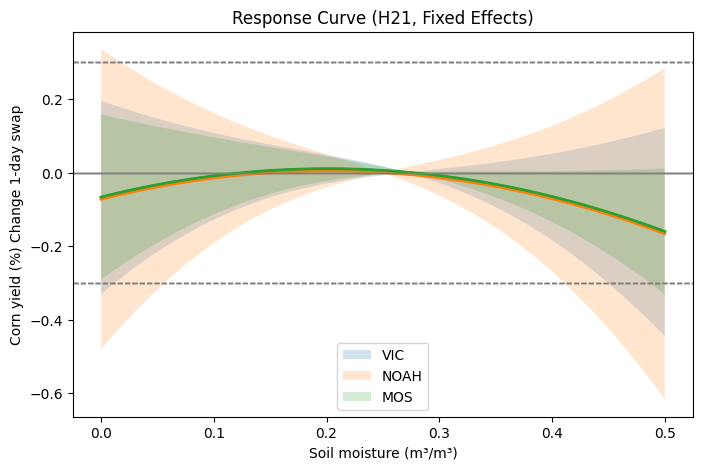

In [130]:
maxS = 0.5
minS = 0.0
number_of_days = 183
SQUARE_IS_MEAN_OF_SQUARES = True
name_list_arr =['VIC', 'NOAH', 'MOS']
plt.figure(figsize=(8,5))

for (name_i, model_i, results_h21_i, predictions_i, df_set_index_i) in zip(name_list_arr, model_arr, results_h21_arr, predictions_arr, df_set_index_arr):
    
    covariance = results_h21_i.cov
    param_dict = dict(results_h21_i.params)
    soilM_param = param_dict['SoilM_0_100cm']
    soilM2_param = param_dict['SoilM_0_100cm_square']
    
    m0 = df_set_index_i['SoilM_0_100cm'].mean()
    m_grid = np.linspace(minS*1000, maxS*1000, 1000)
    pct, se = zip(*[eff_se_for_m(m) for m in m_grid])
    pct, se = np.array(pct), np.array(se)
    lo, hi = pct - 1.96*se, pct + 1.96*se
    
    plt.plot(m_grid/1000, pct, lw=2)
    plt.fill_between(m_grid/1000, lo, hi, alpha=0.2, label=name_i)
    plt.axhline(0, lw=1, color='gray')
    plt.axhline(.3, lw=1, ls='--', color='gray')
    plt.axhline(-.3, lw=1, ls='--', color='gray')
    plt.xlabel('Soil moisture (m³/m³)')
    plt.ylabel('Corn yield (%) Change 1-day swap')
    plt.title('Response Curve (H21, Fixed Effects)')

plt.legend()